In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.utils.data import random_split
import os
import io
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    # def __init__(self, csv_file, root_dir, transform=None):
    def __init__(self, csv_file, root, transform=None):
        self.annotations = pd.read_csv(csv_file)
        # Define a dictionary mapping integers to labels
        label_map = {"SSA": 0, "HP": 1}
        self.annotations["Majority Vote Label"] = self.annotations[
            "Majority Vote Label"
        ].map(label_map)
        # self.root_dir = root_dir
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        img_name = os.path.join(self.root, self.annotations.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.annotations.iloc[idx, 1]  # Class label
        # label = torch.tensor(label)
        # label = [1 if self.annotations.iloc[idx, 1] == 'SSA' else 0 for idx in range(len(self.annotations))]

        if self.transform:
            image = self.transform(image)
        # image = image.to(torch.float32)
        label = torch.tensor(label)
        label = label.to(torch.long)

        return image, label

In [ ]:
# Define transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/


/content/drive/My Drive


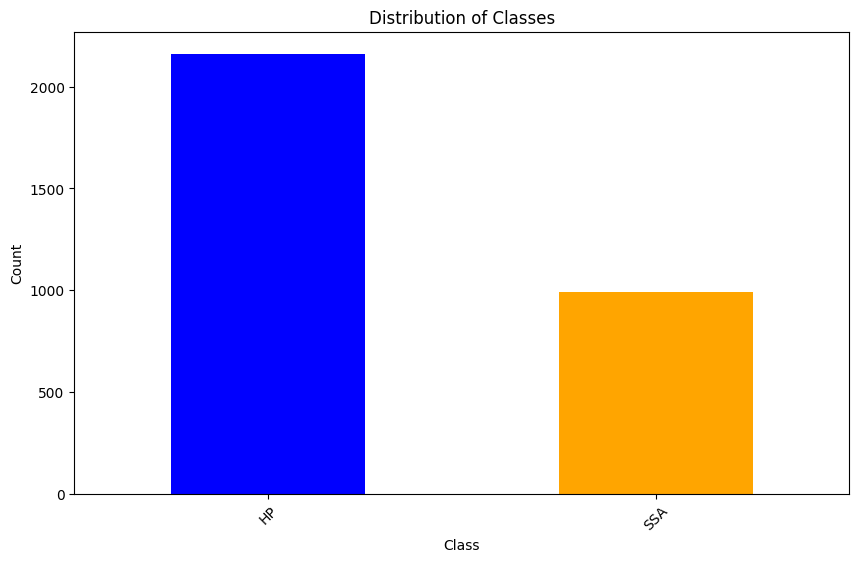

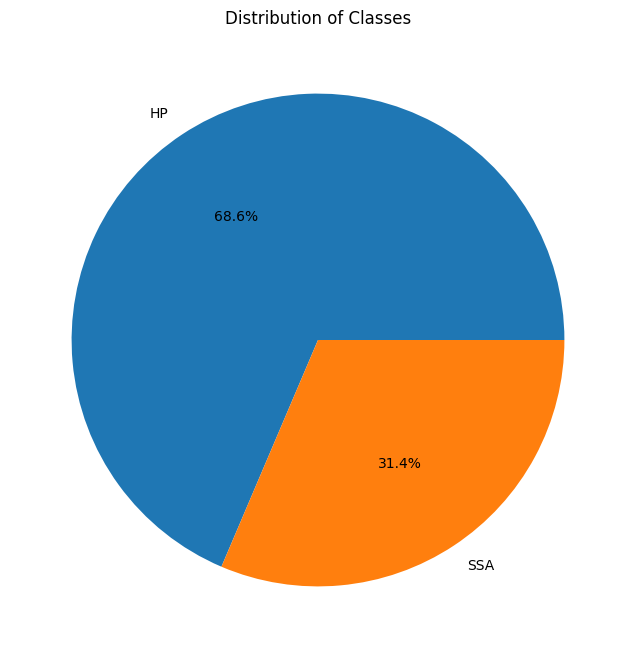

Class Balance:
 HP     0.685914
SSA    0.314086
Name: Majority Vote Label, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load annotations from CSV file
annotations_df = pd.read_csv("annotations.csv")

# Count the occurrences of each class
class_counts = annotations_df['Majority Vote Label'].value_counts()
values = annotations_df['Majority Vote Label'].values
# Plot the distribution of classes using a bar plot
plt.figure(figsize=(10, 6))

colors = ["blue" if val == "SSA" else "orange" for val in values]

 # Change color here
class_counts.plot(kind="bar", color=colors)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of classes using a pie chart
plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.ylabel('')
plt.show()

# Check for class imbalance
class_balance = annotations_df['Majority Vote Label'].value_counts(normalize=True)
print("Class Balance:\n", class_balance)



In [ ]:
# Load dataset
dataset = CustomDataset(csv_file="annotations.csv", root="images", transform=transform)

In [ ]:
# Define sizes for train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [ ]:
train, val, test = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Define data loaders
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
for images, label in train_loader:
    print(images.shape)
    print(label.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
def set_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [ ]:
set_device()

device(type='cuda', index=0)

In [ ]:
from tqdm import tqdm

In [ ]:
def train_nn(model, train_loader, loss_func, scheduler, optimizer, n_epochs):
    # device = torch.device("cpu")
    device = set_device()

    for epoch in range(n_epochs):
        with tqdm(train_loader) as tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch+1}/{n_epochs }")
            # Each epoch has a training and validation phase
            # for phase in ["train"]:
            # if phase == "train":
            #     model.train()  # Set model to training mode
            # else:
            #     model.eval()  # Set model to evaluate mode

            model.train()
            running_loss = 0.0
            running_correct = 0.0
            total = 0

            # Iterate over data.
            for images, labels in tqdm_epoch:
                # images, labels = data
                # Convert tuple labels to tensor format
                # labels = torch.tensor(labels)
                images = images.to(device)
                # labels = torch.tensor(labels)
                labels = labels.to(device)
                total += labels.size(0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    loss = loss_func(outputs, labels)

                    # backward + optimize only if in training phase

                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicted == labels.data)
                scheduler.step()

                epoch_loss = running_loss / total
                epoch_acc = running_correct.double() / total

                # print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # print(
                #     "-Training dataset. Got %d out of %d images correctly (%.3f). Epoch loss: %.3f"
                #     % (running_correct, total, epoch_acc, epoch_loss)
                # )
                tqdm_epoch.set_postfix(
                    accuracy=epoch_acc.item(),
                    loss=epoch_loss,
                )

    print("Finished")
    return model

In [ ]:
model_cv = train_nn(
    resnet18_model,
    train_loader,
    loss_func,
    exp_lr_scheduler,
    optimizer_ft,
    50,
)

Epoch 50/50: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s, accuracy=0.764, loss=0.497]

Finished


In [ ]:
torch.save(model_cv,'trained_model.pth')

In [ ]:
saved_model = torch.load('trained_model.pth', map_location=torch.device('cpu'))

In [ ]:
# Define  architecture
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

resnet18_model = models.resnet18(weights="IMAGENET1K_V1")
num_filters = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_filters, number_of_classes)
# device = torch.device("cpu")
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(resnet18_model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_cv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# evaluate model
import numpy as np


def evaluate_model_on_test_set(model, test_loader):
    pred = np.array([])
    target = np.array([])
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for images, labels in test_loader:

            # images, labels = data
            # Convert tuple labels to tensor format
            # labels = torch.tensor(labels)

            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            pred = np.concatenate((pred, torch.argmax(outputs, 1).cpu().numpy()))
            target = np.concatenate((target, labels.cpu().numpy()))

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print(
        " -Testing dataset. Got %d out of %d images correclty (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc)
    )
    return pred, target

In [ ]:
pred, target = evaluate_model_on_test_set(model_cv, test_loader)

 -Testing dataset. Got 364 out of 474 images correclty (76.793%)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(target, pred)

In [ ]:
label_map = {"SSA": 0, "HP": 1}

<Axes: >

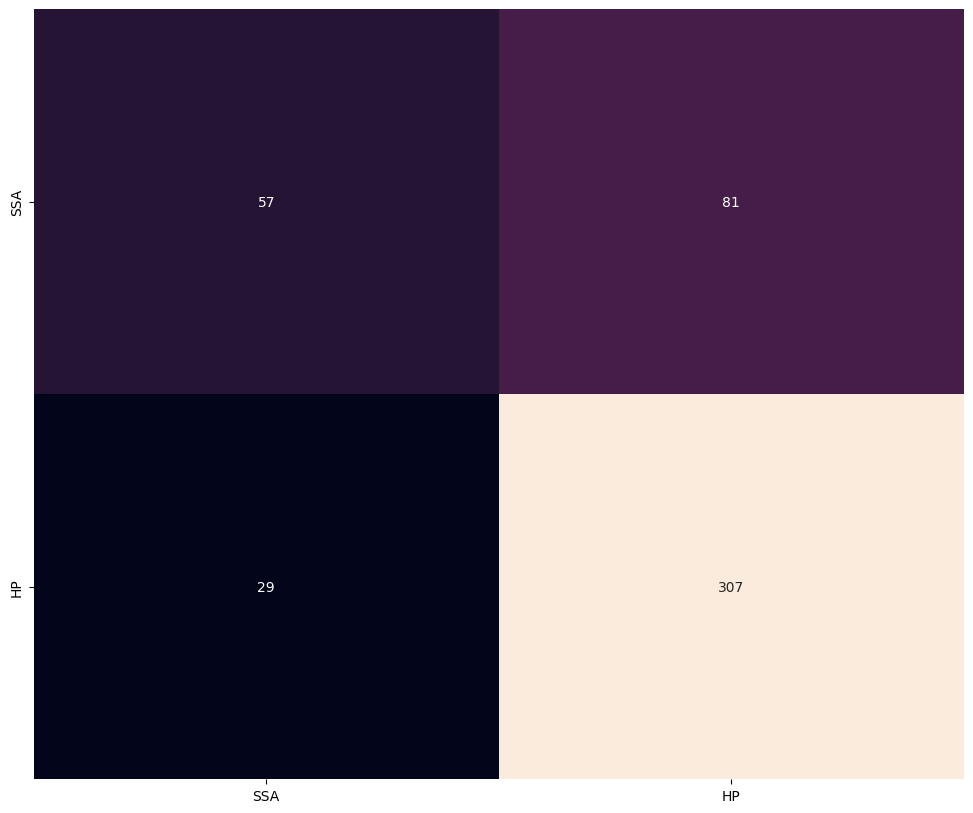

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=label_map.keys(),
    yticklabels=label_map.keys(),
)

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=fec5a28617991426b160ab8ba8719d9ccb702ee8aa5ecbda5e598a08cea102a5
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Define the class for Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        target_layer = self.model._modules[self.target_layer]
        forward_handle = target_layer.register_forward_hook(forward_hook)
        backward_handle = target_layer.register_backward_hook(backward_hook)
        self.forward_handle = forward_handle
        self.backward_handle = backward_handle

    def remove_hooks(self):
        self.forward_handle.remove()
        self.backward_handle.remove()

    def forward_pass(self, input_image):
        return self.model(input_image)

    def backward_pass(self, predicted_class):
        self.model.zero_grad()
        #one_hot_output = torch.FloatTensor(1, self.feature_maps.size(1)).zero_()
        one_hot_output = torch.zeros(1, self.feature_maps.size(1), self.feature_maps.size(2), self.feature_maps.size(3))
        #print(f"size of one_hot_output: {one_hot_output.size()}")
        one_hot_output[0][predicted_class] = 1
        self.feature_maps.backward(gradient=one_hot_output, retain_graph=True)

    def generate_heatmap(self):
        # Compute the weights using global average pooling
        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)

        # Compute the weighted combination of the feature maps
        heatmap = torch.mean(weights * self.feature_maps, dim=1, keepdim=True).squeeze()

        # ReLU operation to keep only positive contributions
        heatmap = nn.ReLU()(heatmap)

        return heatmap

In [ ]:
# # Define the transformations for preprocessing the input image
preprocess = transforms.Compose(
   [
       transforms.Resize((224, 224)),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   ]
 )

In [ ]:
def genrate_heatmap(image_path, preprocess):
    for img in image_path:
        # Load and preprocess the input image
        input_image = Image.open(img)
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)
        # Initialize Grad-CAM
        grad_cam = GradCAM(model=saved_model, target_layer="layer4")
        # Forward pass
        output = grad_cam.forward_pass(input_batch)

        # Get the predicted class
        predicted_class = torch.argmax(output, dim=1).item()
        # Backward pass
        grad_cam.backward_pass(predicted_class)
        # Generate Grad-CAM heatmap
        heatmap = grad_cam.generate_heatmap().detach().numpy()

        # Resize the heatmap to match the size of the input image
        heatmap = np.uint8(255 * heatmap)
        heatmap = np.uint8((heatmap - np.min(heatmap)) / np.ptp(heatmap) * 255)
        heatmap = np.uint8(np.squeeze(heatmap))

        # Apply colormap for visualization
        heatmap_colored = plt.get_cmap("jet")(heatmap)

        # Convert heatmap_colored to a NumPy array
        heatmap_colored_np = np.array(heatmap_colored)

        input_image_pil = Image.open(img)
        heatmap_colored_image = Image.fromarray(
            (heatmap_colored_np[:, :, :3] * 255).astype(np.uint8)
        )
        heatmap_colored_image_resized = heatmap_colored_image.resize(
            input_image_pil.size
        )

        # Overlay the heatmap on the input image
        overlayed_image = Image.blend(
            input_image_pil.convert("RGBA"),
            heatmap_colored_image_resized.convert("RGBA"),
            alpha=0.5,
        )

        # Display the overlayed image with heatmap
        plt.imshow(overlayed_image)
        plt.axis("off")
        plt.title(img)
        plt.show()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


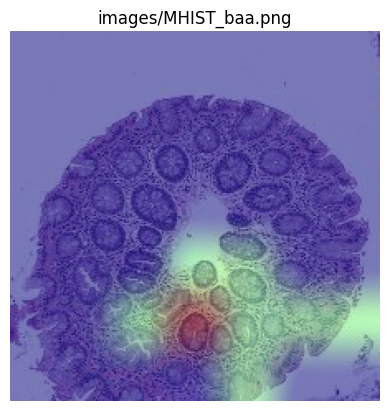

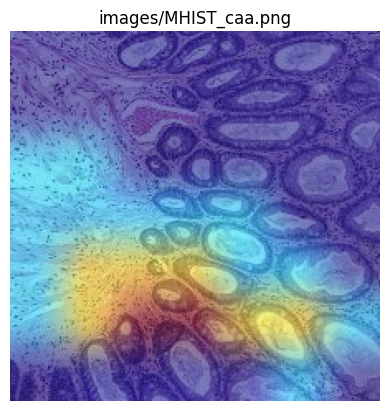

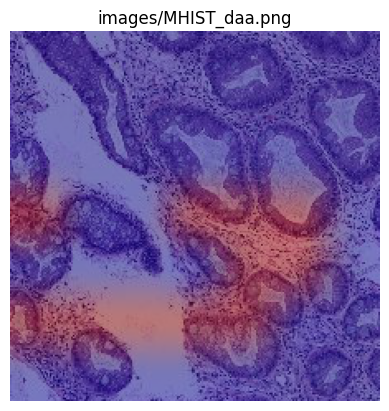

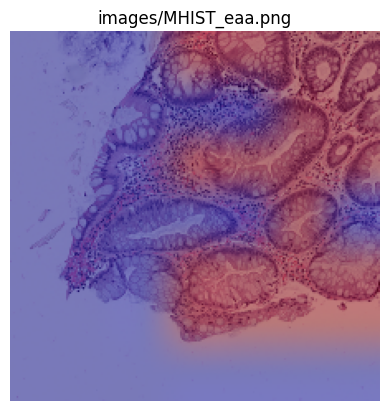

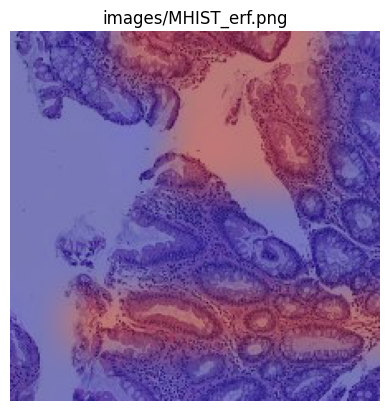

In [ ]:
input_image_paths = ["images/MHIST_baa.png", "images/MHIST_caa.png", "images/MHIST_daa.png", "images/MHIST_eaa.png", "images/MHIST_erf.png"]
genrate_heatmap(input_image_paths, preprocess)

In [ ]:
# Remove hooks
grad_cam.remove_hooks()